In [252]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from hmmlearn import hmm
import sklearn as skl
%matplotlib inline

np.random.seed(5678)

In [ ]:
# initial data cleaning
# file_path = "data/2015_Air_quality_in_northern_Taiwan.csv"
# df = pd.read_csv(file_path, parse_dates=["time"],index_col="time")
# df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: pd.to_numeric(x,errors='coerce'),axis=1).copy()
# df.to_csv("data/2015_removed_marked_data.csv", index=False)

# final data used
file_path = "data/2015_removed_marked_data.csv"
taipai = pd.read_csv(file_path)
taipai = taipai.fillna(method='ffill')
taipai.head()

In [254]:
def bin_winds(col,n):
    cuts = np.linspace(0, 360, n + 1)
    col_binned = pd.cut(col, bins = cuts, labels = False)
    return col_binned

In [255]:
wind_bins = 4
taipai['binned_wind'] = bin_winds(taipai.WIND_DIREC, wind_bins)

# MARKOV MODELING


In [256]:
taipai.station.unique()

array(['Banqiao', 'Cailiao', 'Datong', 'Dayuan', 'Guanyin', 'Guting',
       'Keelung', 'Linkou', 'Longtan', 'Pingzhen', 'Sanchong', 'Shilin',
       'Songshan', 'Tamsui', 'Taoyuan', 'Tucheng', 'Wanhua', 'Wanli',
       'Xindian', 'Xinzhuang', 'Xizhi', 'Yangming', 'Yonghe', 'Zhongli',
       'Zhongshan'], dtype=object)

### Selection of 4 wind directions

In [257]:
songshan = taipai.loc[taipai.station == "Zhongshan"]
songshan.binned_wind.unique()

array([ 1.,  0.,  3.,  2.])

Subset to a smaller sample of the columns

In [258]:
#sample_list = ["NO","SO2","O3","CH4", "NO2", "NOx", "binned_wind"]
sample_list = ["NO","SO2","O3","NO2","NOx","binned_wind"] 
subset_songshan = songshan[sample_list]
subset_songshan.head()

,NO,SO2,O3,NO2,NOx,binned_wind
209904,2.8,11.0,33.0,22.0,25.0,1.0
209905,3.2,7.5,31.0,23.0,26.0,1.0
209906,1.6,6.1,35.0,19.0,20.0,0.0
209907,2.0,4.9,36.0,14.0,16.0,0.0
209908,1.8,4.1,36.0,12.0,14.0,0.0


In [259]:
# fig, axes = plt.subplots(figsize = (10,10))
# subset_songshan.CH4.plot(ax = axes)

### Create the parameters for a markov model

In [260]:
def compute_wind_trans(bin_col):
    """
    Computes the transition matrix for the winds states; necessary for the MM
    
    Arguments
    ---------
    bin_col -- binned wind column; id as 0 indexed integers
    """
    # matrix of state transitions
    n = len(bin_col.unique())
    transition = np.ones((n,n)) 
    for i, j in zip(bin_col[:-1], bin_col[1:]):
        transition[int(i), int(j)] += 1

    # row normalize transition matrix
    row_sum = transition.sum(axis=1)

    return transition / row_sum[:, np.newaxis]

def compute_state_means(df, bin_col):
    """
    Compute an array of state means for each of the states; return a matrix of n states by m obserables
    """
    n, m = len(df[bin_col].unique()), df.shape[1] - 1
    mean_matrix = np.zeros((n,m))
    
    for s in np.sort(df[bin_col].unique()):
        mean_matrix[int(s),:] = df.loc[df[bin_col] == s, df.columns != bin_col].mean(axis=0)
        
    return mean_matrix

def split_train_test(df, p_train):
    """
    Splits our df into train test...scikit probably has this
    """
    i_test = int(df.shape[0] * p_train)
    train, test = df.iloc[:i_test,:], df.iloc[i_test:,:]
    return train, test

def compute_covar(df, bin_col):
    """
    Compute covariance matrices for each time
    """
    n, m = len(df[bin_col].unique()), df.shape[1] - 1
    cov_mat = np.zeros((n, m))
    
    for s in np.sort(df[bin_col].unique()):
        cov_mat[int(s), :] = df.loc[df[bin_col] == s, df.columns != bin_col].var().values

    return cov_mat

def normalize_cols(col):
    """
    Function to apply columnwise to z-normalize the column
    """
    col_mean = np.mean(col)
    col_std = np.std(col)
    return (col - col_mean) / col_std

def confussion_matrx(test, seq):
    """
    Computes the confusion matrix for a given test run
    """
    n = len(test.unique())
    conf_mat = np.zeros((n,n))
    for i, j in zip(seq, test):
        conf_mat[int(i), int(j)] += 1

    return conf_mat

def compute_covar_full(df, bin_col):
    """
    Compute covariance matrices for each time
    """
    n, m = len(df[bin_col].unique()), df.shape[1] - 1
    cov_mat = np.zeros((n,m,m))
    
    for s in np.sort(df[bin_col].unique()):
        cov_mat[int(s),:,:] = df.loc[df[bin_col] == s, df.columns != bin_col].cov().values

    return cov_mat

# TRAINING THE MODEL
First we shall split into training and test
An attempt was made to use PCA as a way to find better parameterization.  

In [261]:
train, test = split_train_test(subset_songshan, 0.5)

# pca = skl.decomposition.PCA()

# pca.fit(train.loc[:,train.columns != "binned_wind"])

# train.loc[:,train.columns != "binned_wind"] = pca.transform(train.loc[:,train.columns != "binned_wind"])

# pca.fit(test.loc[:,train.columns != "binned_wind"])

# test.loc[:,test.columns != "binned_wind"] = pca.transform(test.loc[:,test.columns != "binned_wind"])


Now we'll use the train set to compute transition probabilities and compute state means

In [262]:
tran_mat = compute_wind_trans(train.binned_wind)
wind_means = compute_state_means(train, "binned_wind")
wind_cov = compute_covar(train, "binned_wind")

Now it's time to start the model

In [263]:
%%capture
model = hmm.GaussianHMM(n_components = tran_mat.shape[0], covariance_type="diag")
model.startprob_ = np.ones(tran_mat.shape[0]) / tran_mat.shape[0]
model.transmat_ = tran_mat
model.means_ = wind_means
model.covars_ = wind_cov
ay, sseq = model.sample(100)

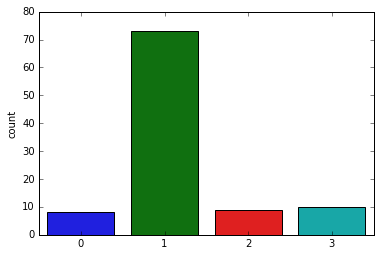

In [264]:
sb.countplot(sseq)

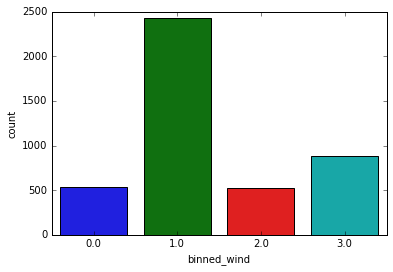

In [265]:
sb.countplot(train.binned_wind)

In [266]:
logprob, seqs = model.decode(test.loc[:,test.columns != "binned_wind"])

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


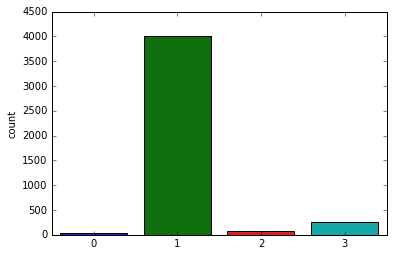

In [267]:
sb.countplot(seqs)

In [268]:
score = sum(seqs == test.binned_wind)/len(seqs)
print("You've gotten a prediction accuracy of: {}".format(score))

You've gotten a prediction accuracy of: 0.7152014652014652


## Attempts at Improving Accuracy 
We're trying z normalizing

In [269]:
subset_songshan_z = subset_songshan.loc[:, subset_songshan.columns != "binned_wind"].apply(normalize_cols, axis=0)
subset_songshan_z["binned_wind"] = subset_songshan.binned_wind

Now to markov again

In [270]:
# get splits
train, test = split_train_test(subset_songshan_z, 0.5)

# compute model parameters
tran_mat = compute_wind_trans(train.binned_wind)
wind_means = compute_state_means(train, "binned_wind")
wind_cov = compute_covar(train, "binned_wind")

# create model
model = hmm.GaussianHMM(n_components = tran_mat.shape[0], covariance_type="diag")
model.startprob_ = np.ones(tran_mat.shape[0]) / tran_mat.shape[0]
model.transmat_ = tran_mat
model.means_ = wind_means
model.covars_ = wind_cov

# evaluate on test data and score
logprob, seqs = model.decode(test.loc[:,test.columns != "binned_wind"])
score = sum(seqs == test.binned_wind)/len(seqs)
print("You've gotten a prediction accuracy of: {}".format(score))

You've gotten a prediction accuracy of: 0.7152014652014652


C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


...it didn't work...

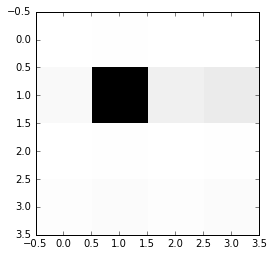

In [271]:
conf = confussion_matrx(test.binned_wind, seqs)
conf.shape
plt.imshow(conf, cmap="Greys", interpolation="nearest")

# LET'S GET AUTOMATED!

In [272]:
def fit_and_test_markov_model(taipai, station, sample_list, train_p = 0.5, full=False):
    """
    Create a markov model and test its predictions; produces score and confusion matrix
    """
    df_station = taipai.loc[taipai.station == station]
    subset_station = df_station[sample_list]

    # get splits
    train, test = split_train_test(subset_station, train_p)

    # compute model parameters
    tran_mat = compute_wind_trans(train.binned_wind)
    wind_means = compute_state_means(train, "binned_wind")
    
    if not full:
        wind_cov = compute_covar(train, "binned_wind")
        cov_type = "diag"
    else:
        wind_cov = compute_covar_full(train, "binned_wind")
        cov_type = "full"

    # create model
    model = hmm.GaussianHMM(n_components = tran_mat.shape[0], covariance_type=cov_type)
    model.startprob_ = np.ones(tran_mat.shape[0]) / tran_mat.shape[0]
    model.transmat_ = tran_mat
    model.means_ = wind_means
    model.covars_ = wind_cov

    # evaluate on test data and score
    logprob, seqs = model.decode(test.loc[:,test.columns != "binned_wind"])
    score = sum(seqs == test.binned_wind)/len(seqs)
    conf_matrix = confussion_matrx(test.binned_wind, seqs)
    return score, conf_matrix

In [273]:
%%capture
stations = []
scores = []
conf_matrices = []
problem = []
for s in taipai.station.unique():
    if len(taipai.loc[taipai.station == s].binned_wind.unique()) < wind_bins:
        problem.append(s)
        continue
        
    try:
        score, conf = fit_and_test_markov_model(taipai, s, sample_list)
        scores.append(score)
        conf_matrices.append(conf)
        stations.append(s)

    except ValueError as e:
        problem.append(s)
        

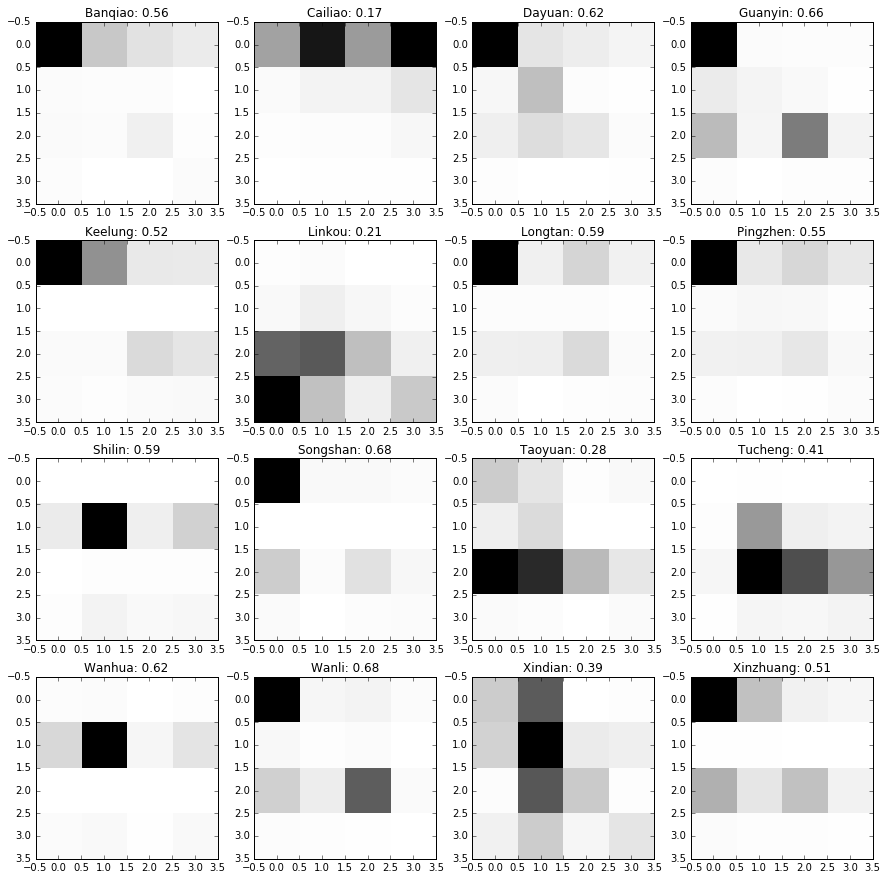

In [274]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15, 15))

i = 0
for row in axes:
    for ax in row:
        ax.imshow(conf_matrices[i], cmap="Greys", interpolation="nearest")
        ax.set_title("{}: {}".format(stations[i], round(scores[i], 2)))
        i += 1

In [275]:
%%capture
stations = []
scores = []
conf_matrices = []
problem = []
for s in taipai.station.unique():
    if len(taipai.loc[taipai.station == s].binned_wind.unique()) < wind_bins:
        problem.append(s)
        continue
        
    try:
        score, conf = fit_and_test_markov_model(taipai, s, sample_list, full=True)
        scores.append(score)
        conf_matrices.append(conf)
        stations.append(s)

    except ValueError as e:
        problem.append(s)
        

In [276]:
len(stations)

17

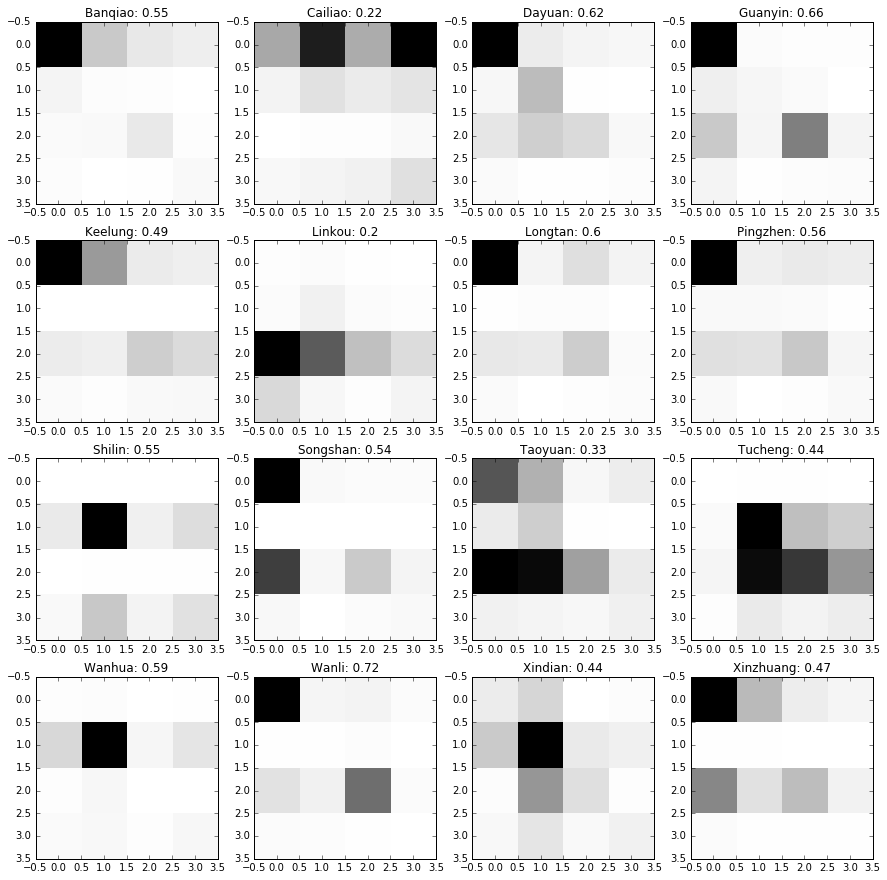

In [277]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15, 15))

i = 0
                         
for row in axes:
    for ax in row:
        ax.imshow(conf_matrices[i], cmap="Greys", interpolation="nearest")
        ax.set_title("{}: {}".format(stations[i], round(scores[i], 2)))
        i += 1

Tide covariance for tomorrow.  



## PCA Testing